# Diagnosing breast cancer using machine learning algorithms

Tomáš Chobola, 2019

### 1. Introduction

This notebook describes how to use machine learning algorithms trained on Breast Cancer Wisconsin (Diagnostic) Data Set from UCI Machine Learning Repository to classify breast cancer. The notebook is accompanied by an application that takes in user input and tries to classify it.

Let's start by importing the data as `numpy` array.

In [1]:
import numpy as np
import random
random.seed(42)

In [2]:
data_array = np.genfromtxt('./breast_cancer_dataset.csv', delimiter=',', dtype='float64, U1, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64')
tmp = np.array([list(elem) for elem in data_array])

To get a basic idea how the data is structured I am going the print out the first element of the `data_array`.

In [3]:
print(data_array[0])

(842302., 'M', 17.99, 10.38, 122.8, 1001., 0.1184, 0.2776, 0.3001, 0.1471, 0.2419, 0.07871, 1.095, 0.9053, 8.589, 153.4, 0.006399, 0.04904, 0.05373, 0.01587, 0.03003, 0.006193, 25.38, 17.33, 184.6, 2019., 0.1622, 0.6656, 0.7119, 0.2654, 0.4601, 0.1189)


The array contains identification number and classificition of the instance in the first two columns. For the analysis and processing I do not need the identification number so I will delete it. Furthermore I need to extract the classification values from the database so I can categorize the data. 

In [4]:
tmp = np.delete(tmp, 0, 1)
results_array = tmp[:,0]
tmp = np.delete(tmp, 0, 1)
data_array = tmp.astype(np.float)

Now I have two arrays, `results_array` corresponds to the categorization and `data_array` corresponds to the attributes of each instance.

In [5]:
print('benign instances:', np.count_nonzero(results_array == 'B'), ',', 'malignant instances:', np.count_nonzero(results_array == 'M'))

benign instances: 357 , malignant instances: 212


In [6]:
print(data_array)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]


In [7]:
print('number of instances =', len(data_array))

number of instances = 569


The `data_array` consists of 569 instances of attributes of digitized image of a fine needle aspirate (FNA) of a breast mass. According to the UCI Machine Learning Repository the first ten values describe radius (mean of distances from center to points on the perimeter), texture (standard deviation of gray-scale values), perimeter, area, smoothness (local variation in radius lengths), compactness (perimeter^2 / area - 1.0), concavity (severity of concave portions of the contour), concave points (number of concave portions of the contour), symmetry and fractal dimension ("coastline approximation" - 1). The reamining values are mean, standard error and "worst" or largest (mean of the three largest values) of these features.

Now that I have the data imported I can create scatter plot of two features so I can visualise the distribution.

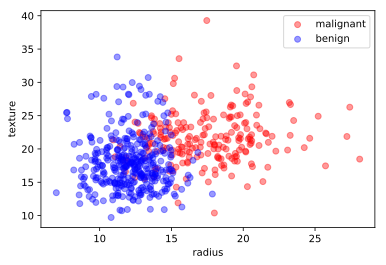

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi']=1000

x_values_M = []
y_values_M = []
x_values_B = []
y_values_B = []

for i in range(len(data_array)):
    if results_array[i] == 'M':
        x_values_M.append(data_array[i][0])
        y_values_M.append(data_array[i][1])
    else:
        x_values_B.append(data_array[i][0])
        y_values_B.append(data_array[i][1])
        
plt.scatter(x_values_M, y_values_M, color='red', label='malignant', alpha=0.4)
plt.scatter(x_values_B, y_values_B, color='blue', label='benign', alpha=0.4)

plt.xlabel('radius')
plt.ylabel('texture')
plt.legend(loc=1)
plt.show()

This is just a visualisation of two parameters to get a better grasp on the data. I can see that there is a visible difference between the two categories and it looks like a perfect classification problem.

### 2. Using the k-nearest neighbours algorithm
The kNN algorithm is one of the most commonly used machine learning algorithms. It is mainly used for classification and regression. The classification is based on $k$, which is number of nearest neighbours that are analysed and used for classification of a object.

For presentation purposes I am going to create a synthetic dataset with two clusters describing two features.

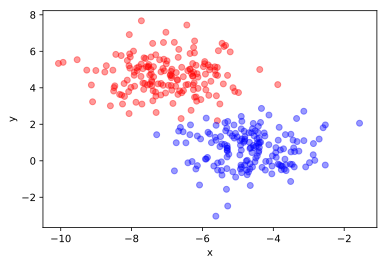

In [9]:
from sklearn.datasets.samples_generator import make_blobs

x, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=1, random_state=12)
plt.scatter(x[y == 0, 0], x[y == 0, 1], color="red", alpha=0.4)
plt.scatter(x[y == 1, 0], x[y == 1, 1], color="blue", alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

This generated scatter plot shows two clusters distinguished by color and on those I can provide an explination how the kNN algorithm works.
Let's say there is a new element with features $x=-7$ and $y=3$. How will I decide if the element will be classified as red or blue?

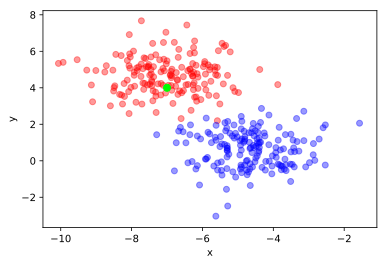

In [10]:
plt.scatter(x[y == 0, 0], x[y == 0, 1], color="red", alpha=0.4)
plt.scatter(x[y == 1, 0], x[y == 1, 1], color="blue", alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter([-7],[4], color="lime", s=50)
plt.show()

The green point is closest to the red cluster. If I say that the $k = 5$, then I can see that if I choose five closest points to the green element, all of them will be red. This means that the green point would be classified as red. If, for example, three out of the five closest neighbours would be blue, the object would be classified as blue since the classification is based on a majority function.

For humans it can be easy to classify objects based on their position in 2-dimensional or 3-dimensional space just by looking at the plots. For computers however, the task is a little more complicated. The kNN algorithm uses distance functions to calculate the distance between objects. Then it chooses the $k$ closest elements and classifies it accordingly. Thanks to the distance function I can calculate the size of separation between objects in space. Euclidian metric is often used to calculate the distance between objects:

$$dist(A,B)=\sqrt\frac{\sum_{i=1}^{m}(x_i - y_i)^2}{m}$$

Where $A=(x_1, x_2, ..., x_m)$, $B=(y_1, y_2, ..., y_m)$ and $m$ is the dimension of the space.

Now that I know how the algorithm works I can use it to make predictions of new instances. I am going to use two thirds of the UCI dataset for learning and one third for validating. Also I am only going to use the first ten values of each instance since those are the most important for categorization.

In [11]:
data_array = data_array[:,[0,1,2,3,4,5,6,7,8,9]]

In [12]:
import math

# Splits data into two datasets, first part is intended for learning and second part is intended for validation.
def split_data(data_array, results_array, training_size = 0.67):
    training_data = [] # training data (first 67% of the original dataset) = first part
    training_results = [] # training data results
    validation_data = [] # validation data (remaining 33% of the original dataset) = second part
    validation_results = [] # validation data results

    training_length = math.ceil(len(data_array) * training_size)
    for i in range(training_length):
        training_data.append(data_array[i])
        training_results.append(results_array[i])

    for i in range(len(data_array) - training_length):
        validation_data.append(data_array[i + training_length])
        validation_results.append(results_array[i + training_length])

    training_data = np.array(training_data)
    training_results = np.array(training_results)
    validation_data = np.array(validation_data)
    validation_results = np.array(validation_results)

    return training_data, training_results, validation_data, validation_results

In [13]:
training_data, training_results, validation_data, validation_results = split_data(data_array, results_array)

The data needs to be normalized first because some of the attributes has gross influence on the distance function and would mess with the results.

In [14]:
import statistics
from sklearn import preprocessing

# Normalization for the training data and saving the means and standard deviation values for
# normalizing the validation dataset and input entries.
def normalize_training(data_array):
    means = np.sum(data_array, axis=0)/len(data_array)
    stdevs = []
    for i in range(len(data_array)):
        stdevs.append(statistics.stdev(data_array[i]))

    data_array = preprocessing.normalize(data_array)

    return data_array, means, stdevs

# Normalization for the validation dataset and input entries.
def normalize(data_array, means, stdevs, multidimensional):
    if multidimensional == False:
        for i in range(len(data_array)):
            data_array[i] = (data_array[i] - means[i])/stdevs[i]
            
    else:
        for i in range(len(data_array)):
            for j in range(len(data_array[i])):
                data_array[i][j] = (data_array[i][j] - means[j])/stdevs[j]
    
    return data_array

In [15]:
print(data_array)

[[1.799e+01 1.038e+01 1.228e+02 ... 1.471e-01 2.419e-01 7.871e-02]
 [2.057e+01 1.777e+01 1.329e+02 ... 7.017e-02 1.812e-01 5.667e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 1.279e-01 2.069e-01 5.999e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 5.302e-02 1.590e-01 5.648e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 1.520e-01 2.397e-01 7.016e-02]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 1.587e-01 5.884e-02]]


In [16]:
training_data, means, stdevs = normalize_training(training_data)
validation_data = normalize(validation_data, means, stdevs, True)

The `sklearn` library already offers implemented classifier so I am going to use it. The precision and quality of the classifier is based on the $k$ value. In order to get the best results I will pick a value in range $[1,50]$.

In [17]:
from sklearn.neighbors import KNeighborsClassifier

def best_k():
    accuracy = 0
    k = 1

    for i in range(1, 50):
        classifier = KNeighborsClassifier(n_neighbors = i)
        classifier.fit(training_data, training_results)
        
        if classifier.score(validation_data, validation_results) > accuracy:
            accuracy = classifier.score(validation_data, validation_results)
            k = i

    return k

Now I will use the `best_k` function to initialize the classifier. After that the training data will be fit into the kNN model.

In [18]:
k = best_k()
classifier = KNeighborsClassifier(n_neighbors = k)
classifier.fit(training_data, training_results)

print('k =', k)
print('accuracy =', classifier.score(validation_data, validation_results))

k = 4
accuracy = 0.93048128342246


The best $k$ value in this case is 4 and it gives accuracy around 93% on the validation data. The classifier is set so it can be used for making predictions.

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(validation_results, classifier.predict(validation_data))
print(cm)

[[137   7]
 [  6  37]]


From the confusion matrix I can see the high accuracy of the model from the strong majority of correctly classified instances.

In [20]:
instance_a = [17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871]
instance_b = [11.94,18.24,75.71,437.6,0.08261,0.04751,0.01972,0.01349,0.1868,0.0611]

instance_a = normalize(instance_a, means, stdevs, False)
instance_b = normalize(instance_b, means, stdevs, False)

instance_a = np.array(instance_a).reshape(1,-1).astype(np.float64)
instance_b = np.array(instance_b).reshape(1,-1).astype(np.float64)

In [21]:
print('Prediction of instance A:', classifier.predict(instance_a))
print('Prediction of instance B:', classifier.predict(instance_b))

Prediction of instance A: ['M']
Prediction of instance B: ['B']


From the predictions I can see that the instance A was classified as malignant and instance B was classified as benign which corresponds to the classifications that were stated in the original dataset. 

### 3. Using the Gaussian Naive Bayes algorithm

Next, I am going to use the Gaussian Naive Bayes (GNB) algorithm to categorize and make predictions on the same dataset as in the previous section. The reasoning behind the choice for GNB is that I am dealing with continuous data and I assume that the distribution is normal which is what GNB is made for.

The GNB is build on the Bayes' theorem which describes the probablity of an event based on prior circumstances. For example when calculating the probablity of a person having Alzheimer's disease the person's age plays a huge part in the probablity. It is very rare for someone in their twenties and thirties to develop the disease but the likelihood of developing Alzheimer's doubles about every five years after age 65. This relationship is exacly what the Bayes' theorem describes and is stated mathematically as:

$$P(A\mid B)=\frac{P(B\mid A)\; P(A)}{P(B)}$$

- $A$ and $B$ are events and $P(B)\neq0$.<br>
- $P(A\mid B)$ is conditional probability and it describes the chance of event $A$ happening when $B$ is true.

GNB works with normal distribution which is shown on following plot.

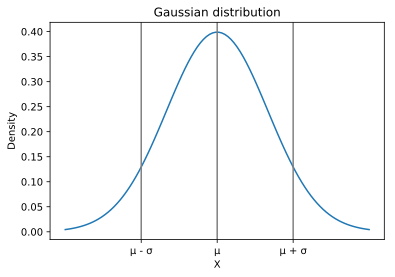

In [22]:
import scipy.stats as stats

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.axvline(0, color='grey')
plt.axvline(-1.5, color='grey')
plt.axvline(1.5, color='grey')

plt.xticks([-1.5,0,1.5], ['μ - σ','μ','μ + σ'])
plt.xlabel('X')
plt.ylabel('Density')

plt.title('Gaussian distribution')
plt.show()

- $\mu$ is the mean of distribution
- $\sigma$ is the standard deviation

The Gaussian Naive Bayes is combination of those two priciples and the probability is described by following expression:

$${\displaystyle p\,(x_{i}\mid C_{k})={\frac {1}{\sqrt {2\pi \sigma _{x_{i},k}^{2}}}}\,e^{-{\frac{1}{2}}{\frac {(x-\mu _{x_{i},k})^{2}}{\sigma _{x_{i},k}^{2}}}}}$$

$P(x_{i}\mid C_{k})$ represents the probability of $x_{i}$ (parameter of the instance indexed $i$) given a class $C_{k}$ (in this notebook I am only using two classes - benign, malignant). The variables on the right side of the equation are:
- $\mu _{x_{i},k}$ is the mean of values $x_{i}$ associated with the class $C_{k}$
- $\sigma _{x_{i},k}^{2}$ is the variance of the values in $x_{i}$ associated with class $C_{k}$

For example attributes indexed as $i=1,2,3$ are:
- $x_{1}$ represents radius
- $x_{2}$ represents texture
- $x_{3}$ represents perimeter

Finally when the probability of every attribute is calculated the classification can be made.

$$P(X\mid C_{k}) = \prod_{i=1}^{m} p\,(x_{i}\mid C_{k})$$

Where $X=(x_1, x_2, ..., x_m)$. In my case there are only two classes and so it is required to aquire two probabilities, $P(X\mid C_{1})$ and $P(X\mid C_{2})$. Now I can get the probability of $X$ being part of class $C_{k}$ as:

$$P(C_{k}\mid X) = \frac{P(X\mid C_{k})\; P(C_{k})}{\sum_{j=1}^{n}P(X\mid C_{j})}$$

After analysing the mathematical background of the GNB I can begin with the implementation of the classifier.

I will start with importing the classifier from `sklearn` library and I will use the default setting. After that I will fit the classifier with data from the beginning of the notebook so it could be later used for making accurate predictions. Normalization is not necessary since the GNB only compares the same types of attributes with each other. So I am going to import the raw data once more.

In [23]:
data_array = np.genfromtxt('./breast_cancer_dataset.csv', delimiter=',', dtype='float64, U1, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64')
tmp = np.array([list(elem) for elem in data_array])

tmp = np.delete(tmp, 0, 1)
results_array = tmp[:,0]
tmp = np.delete(tmp, 0, 1)
data_array = tmp.astype(np.float)

training_data, training_results, validation_data, validation_results = split_data(data_array, results_array)

In [24]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB(priors=None, var_smoothing=1e-09)
classifier.fit(training_data, training_results)

GaussianNB(priors=None, var_smoothing=1e-09)

Now that the classifier is ready I can test its accuracy on the validation data. The used datasets are the same as in the previous section so I can compare the performance.

In [25]:
print('accuracy =', classifier.score(validation_data, validation_results))

accuracy = 0.9625668449197861


When testing the classifier on the validation data the model peaks with accuracy around 96% which is a little higher than the accuracy of the kNN model.

In [26]:
cm = confusion_matrix(validation_results, classifier.predict(validation_data))
print(cm)

[[140   4]
 [  3  40]]


From the confusion matrix I can see that the errors in classification are similiar. Even though the percentual accuracy is a little bit higher it does not make a difference because of the small size of the dataset.

In [27]:
instance_a = [17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189]
instance_b = [11.94,18.24,75.71,437.6,0.08261,0.04751,0.01972,0.01349,0.1868,0.0611,0.2273,0.6329,1.52,17.47,0.00721,0.00838,0.01311,0.008,0.01996,0.002635,13.1,21.33,83.67,527.2,0.1144,0.08906,0.09203,0.06296,0.2785,0.07408]

instance_a = np.array(instance_a).reshape(1,-1).astype(np.float64)
instance_b = np.array(instance_b).reshape(1,-1).astype(np.float64)

print('Prediction of instance A:', classifier.predict(instance_a))
print('Prediction of instance B:', classifier.predict(instance_b))

Prediction of instance A: ['M']
Prediction of instance B: ['B']


From the predictions I can see that the instance A was classified as malignant and instance B was classified as benign which corresponds to the classifications that were stated in the original dataset. 

### 4. Using neural network

The final classification process I am presenting is the use of neural network to analyze the data. 

The neural network is a system of connected nodes which are producing output values based on input. Those values are propagated through the network to the last node that produces the resulting value. The neural network works in a similar way as neurons in a biological brain. The nodes (or neurons) are connected to each other by edges and each edge has a weight. The processes happening inside the nodes and the weights of the edges are the main source of the predictions. I am using `Sequential` from `keras` library which uses backpropagation algorithm for altering the network in a particular way so it can make precise predictions.

In [28]:
from keras import Sequential
from keras.layers import Dense
from numpy.random import seed
seed(142857)

Using TensorFlow backend.


After importing the libraries I am going to define the neural network. The input layer takes in 30 values which is the dimension of the space I am working in. Next I add first and second hidden layer with 16 and 8 nodes. Those two layers are using rectifier as activation function for its faster learning rate compared to the sigmoid function:

$$f(x)=max(0, x)$$

The output layer is than using classic sigmoid function because it works well for classification problems:

$$S(x)=\frac{1}{1 + e^{-x}}$$

In [29]:
network = Sequential()
# first hidden layer
network.add(Dense(16, activation='relu', kernel_initializer='random_normal', input_dim=30))
# second hidden layer
network.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
# output layer
network.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

network.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


Here is a visualization of the compiled neural network I have made with online tool [NN-SVG](http://alexlenail.me/NN-SVG/index.html). 

![title](images/nn.png)

It is important that the neural network does not waste its effort on learning the atributes with the biggest range so I am going to normalize the data as in the section with kNN classifier.

In [30]:
training_data, means, stdevs = normalize_training(training_data)
validation_data = normalize(validation_data, means, stdevs, True)

The neural network needs to work with numerical values so I am going to substitute the letters describing the category with values 0 and 1. Next the network will be trained on the training dataset in 100 iterations.

In [31]:
training_results = np.where(training_results == 'M', 1, training_results)
training_results = np.where(training_results == 'B', 0, training_results)

network.fit(training_data, training_results, batch_size=10, epochs=100, verbose=0)
# by setting the parameter verbose to 0 I am suppressing the default output and the final output is printed out by the following cell

Instructions for updating:
Use tf.cast instead.


Now that the training is done I can evaluate the network.

In [32]:
evaluation = network.evaluate(training_data, training_results)
print(evaluation)

382/382 [==============================] - 0s 110us/step
[0.6865089807210792, 0.5575916245969802]


The neural network has accuracy around 93% (the value fluctuates because of the randomness of the NN learning algorithm and is different with every iteration) based on the training data. This result is quite high and I can trust it that the classifications will be accurate. 

In order to see the precision on the validation set I am again going to use the confusion matrix.

In [33]:
validation_results = np.where(validation_results == 'M', 1, validation_results)
validation_results = np.where(validation_results == 'B', 0, validation_results)
validation_results = np.array(validation_results).reshape(-1,1).astype(np.float64)

prediction = network.predict(validation_data)
prediction = prediction > 0.5

cm = confusion_matrix(validation_results, prediction)
print(cm)

[[144   0]
 [ 43   0]]


The confusion matrix is very similiar to the ones from prevoius models. To get the accuracy score I simply use the `accuracy_score` function from `sklearn` library.

In [34]:
from sklearn.metrics import accuracy_score

print('accuracy =', accuracy_score(validation_results, prediction))

accuracy = 0.7700534759358288


The neural network has accuracy around 96% on the validation data.

### 5. Conclusion
After testing the k-nearest neighbours algorithm, the Gaussian Naive Bayes algorithm and simple neural network on UCI dataset made out of instances of atributes of digitized image of a fine needle aspirate (FNA) of a breast mass I can say that all three of them performed significantly well. Although the dataset is small and the number of data is not sufficient for any real-life application. On a positive side of things the classification models could be used on different datasets and when properly set they could produce accurate and meaningful predictions.